In [423]:
import matplotlib.pyplot as plt
import numpy as np
import re as regex
import seaborn as sns
import pandas as pd
import json
from pandas.io.json import json_normalize
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor,LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
%matplotlib inline

In [424]:
Titanic = pd.read_csv("titanic_train.csv")
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [425]:
def cleanColumns(dataFrame):
    columnDictionary = {} #to be used by rename function
    dataFrameColumns = dataFrame.columns
    for  column in dataFrameColumns:
        strColumn = str(column) #cast the values as strings
        columnDictionary[strColumn] = str (column.strip()).lower() #trim whitespaces and convert cases to lowercase
    dataFrameColumnsCleaned = dataFrame.rename(columns=columnDictionary)
    return dataFrameColumnsCleaned

In [426]:
# @param dataFrame - type = pandas dataframe
# @param missingTolerance - type = numeric, desc=specifies percentage of missing values in column for column to be dropped
# @return pandasDataframe
def dropExcessivelyLargeValueMissingColumns(dataFrame, missingTolerance = 40):
    for column in dataFrame:
        totalValues = len(dataFrame[column])
        missingValues = len(dataFrame[dataFrame[column].isnull()][column])
        missingValuePercentage = float(missingValues) / float(totalValues)
        if ((missingValuePercentage*100) > missingTolerance):
            dataFrame.drop(column,axis=1, inplace= True)
        
    return dataFrame

In [427]:
# @param dataFrame - pandas dataframe
# @param target - Missing values column we want to fill
# @return pandasDataframe
def dropMissingRowsExcludeTarget(dataFrame, target):
    for column in dataFrame:
        if (column == target):
            continue
        emptyRows = dataFrame[dataFrame[column].isnull()]
        indexes = emptyRows.index
        for index in indexes:
            newDataFrame = dataFrame.drop(labels=index, axis=0, inplace= True)
    return dataFrame

In [428]:
# @param dataFrame - type = pandasDataframe
# @param mutuallyExclusive - type = bool, desc=if values are mutually exclusive drop one
# @param maxUnique - type = int, desc=determines if categorical column should be ignored and dropped if unique elements exceed a maximum value
# @return pandasDataframe
def convertCategoricalsToNumericDichotomous(dataFrame, mutuallyExclusive=True, maxUnique=5, dropMaxExceeder=True):
    for column in dataFrame:
        columnData = dataFrame[column]
        Nonulls = columnData[columnData.notnull()]
        columnDataType = type(Nonulls[1])
        if (columnDataType != type('a string')):
            continue
        if (len(columnData.unique()) > maxUnique):
            if (dropMaxExceeder):
                dataFrame.drop(column,axis=1, inplace= True)
            continue
        columnDummies = pd.get_dummies(columnData, drop_first=mutuallyExclusive)
        dataFrame = dataFrame.join(columnDummies)
        dataFrame.drop(column,axis=1, inplace= True)
    return dataFrame
        

In [429]:
def fillNaNfloat(mean,std):
    return np.random.uniform((mean - std), (mean + std))

In [430]:
#MCT - Measures of Central Tendency
def fillMissingByMCT(dataFrame,target):
    mean = dataFrame[target].mean()
    std = dataFrame[target].std()
    dataFrame[target].replace(np.nan, int(fillNaNfloat(mean, std)), inplace=True)
    return dataFrame

In [431]:
def fillMissingByprediction(dataFrame, target, model):
    manDataFrame = dropExcessivelyLargeValueMissingColumns(dataFrame)
    manDataFrame = dropMissingRowsExcludeTarget(manDataFrame, target)
    manDataFrame = convertCategoricalsToNumericDichotomous(manDataFrame)
    #Extractions for algorithm
    KnownTrainData = manDataFrame[manDataFrame[target].notnull()]
    toPredict = manDataFrame[manDataFrame[target].isnull()]
    toPredictX = toPredict.drop(target,axis=1)
    y = KnownTrainData[target]
    XKownData = KnownTrainData.drop(target,axis=1)
    X = XKownData
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    model.fit(X_train, y_train)
    toPredictPredictions = model.predict(toPredictX)
    i = 0
    for toPredictPrediction in toPredictPredictions:
        toPredictPredictions[i] = abs(int(toPredictPrediction))
        i = i + 1
    listPP = list(toPredictPredictions)
    toPredict.drop(target,axis=1, inplace=True)
    toPredict[target] = listPP
    newManDataFrame = pd.concat([KnownTrainData,toPredict], sort=True)
    return newManDataFrame

In [432]:
np.arange(3)

array([0, 1, 2])

In [434]:
compFT = fillMissingByprediction(Titanic[['Survived','Pclass','Sex','SibSp','Parch','Fare','Embarked','Age']], 'Age')

/home/fanan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
compFT = fillMissingByMCT(filledTitan,'Age')
compFT

In [183]:
Titanic.drop('PassengerId',axis=1, inplace= True)

In [435]:
Titanic = dropExcessivelyLargeValueMissingColumns(Titanic)
Titanic = dropMissingRowsExcludeTarget(Titanic, 'Age')
Titanic = convertCategoricalsToNumericDichotomous(compFT)
Titanic.head()
KnownData = Titanic[Titanic['Age'].notnull()]
toPredict = Titanic[Titanic['Age'].isnull()]
toPredictX = toPredict.drop('Age',axis=1)
y = KnownData['Age']
XKownData = KnownData.drop('Age',axis=1)
X = XKownData

In [436]:
#This area is for testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
accuracy = lr.score(X_test, y_test)
print('Accuracy', (accuracy*100))
print('A break between predictions')

i = 0
for prediction in predictions: 
    predictions[i] = abs(int(prediction))
    i = i + 1
predictions
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
accuracy = lr.score(X_test, y_test)
print('Accuracy', (accuracy*100))

('MAE:', 8.542721337494237)
('MSE:', 137.344975272458)
('RMSE:', 11.71942725872122)
('Accuracy', 26.60943046588852)
A break between predictions
('MAE:', 8.494561797752809)
('MSE:', 138.46289078651685)
('RMSE:', 11.767025570912848)
('Accuracy', 26.60943046588852)


In [437]:
toPredictPredictions = lr.predict(toPredictX)
print(len(toPredict['Age']))
print(len(toPredictPredictions))
toPredictPredictions
i = 0
for toPredictPrediction in toPredictPredictions:
    toPredictPredictions[i] = abs(int(toPredictPrediction))
    i = i + 1
listPP = list(toPredictPredictions)
#toPredict.drop('Age',axis=1, inplace=True)
toPredict['Age'] = listPP
toPredict

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required.

In [438]:
newTitanic = pd.concat([KnownData,toPredict], sort=True)
newTitanic

,Age,Fare,Parch,Pclass,Q,S,SibSp,Survived,male
0,22.0,7.2500,0,3,0,1,1,0,1
1,38.0,71.2833,0,1,0,0,1,1,0
2,26.0,7.9250,0,3,0,1,0,1,0
3,35.0,53.1000,0,1,0,1,1,1,0
4,35.0,8.0500,0,3,0,1,0,0,1
6,54.0,51.8625,0,1,0,1,0,0,1
7,2.0,21.0750,1,3,0,1,3,0,1
8,27.0,11.1333,2,3,0,1,0,1,0
9,14.0,30.0708,0,2,0,0,1,1,0
10,4.0,16.7000,1,3,0,1,1,1,0


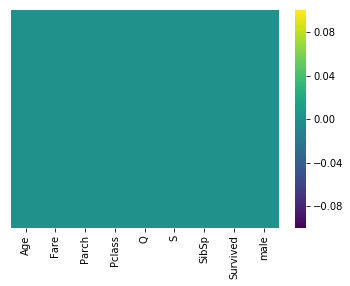

In [439]:
sns.heatmap(newTitanic.isnull(), yticklabels=False, cmap="viridis")

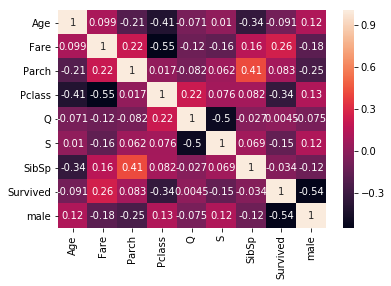

In [440]:
sns.heatmap(newTitanic.corr(), annot=True)

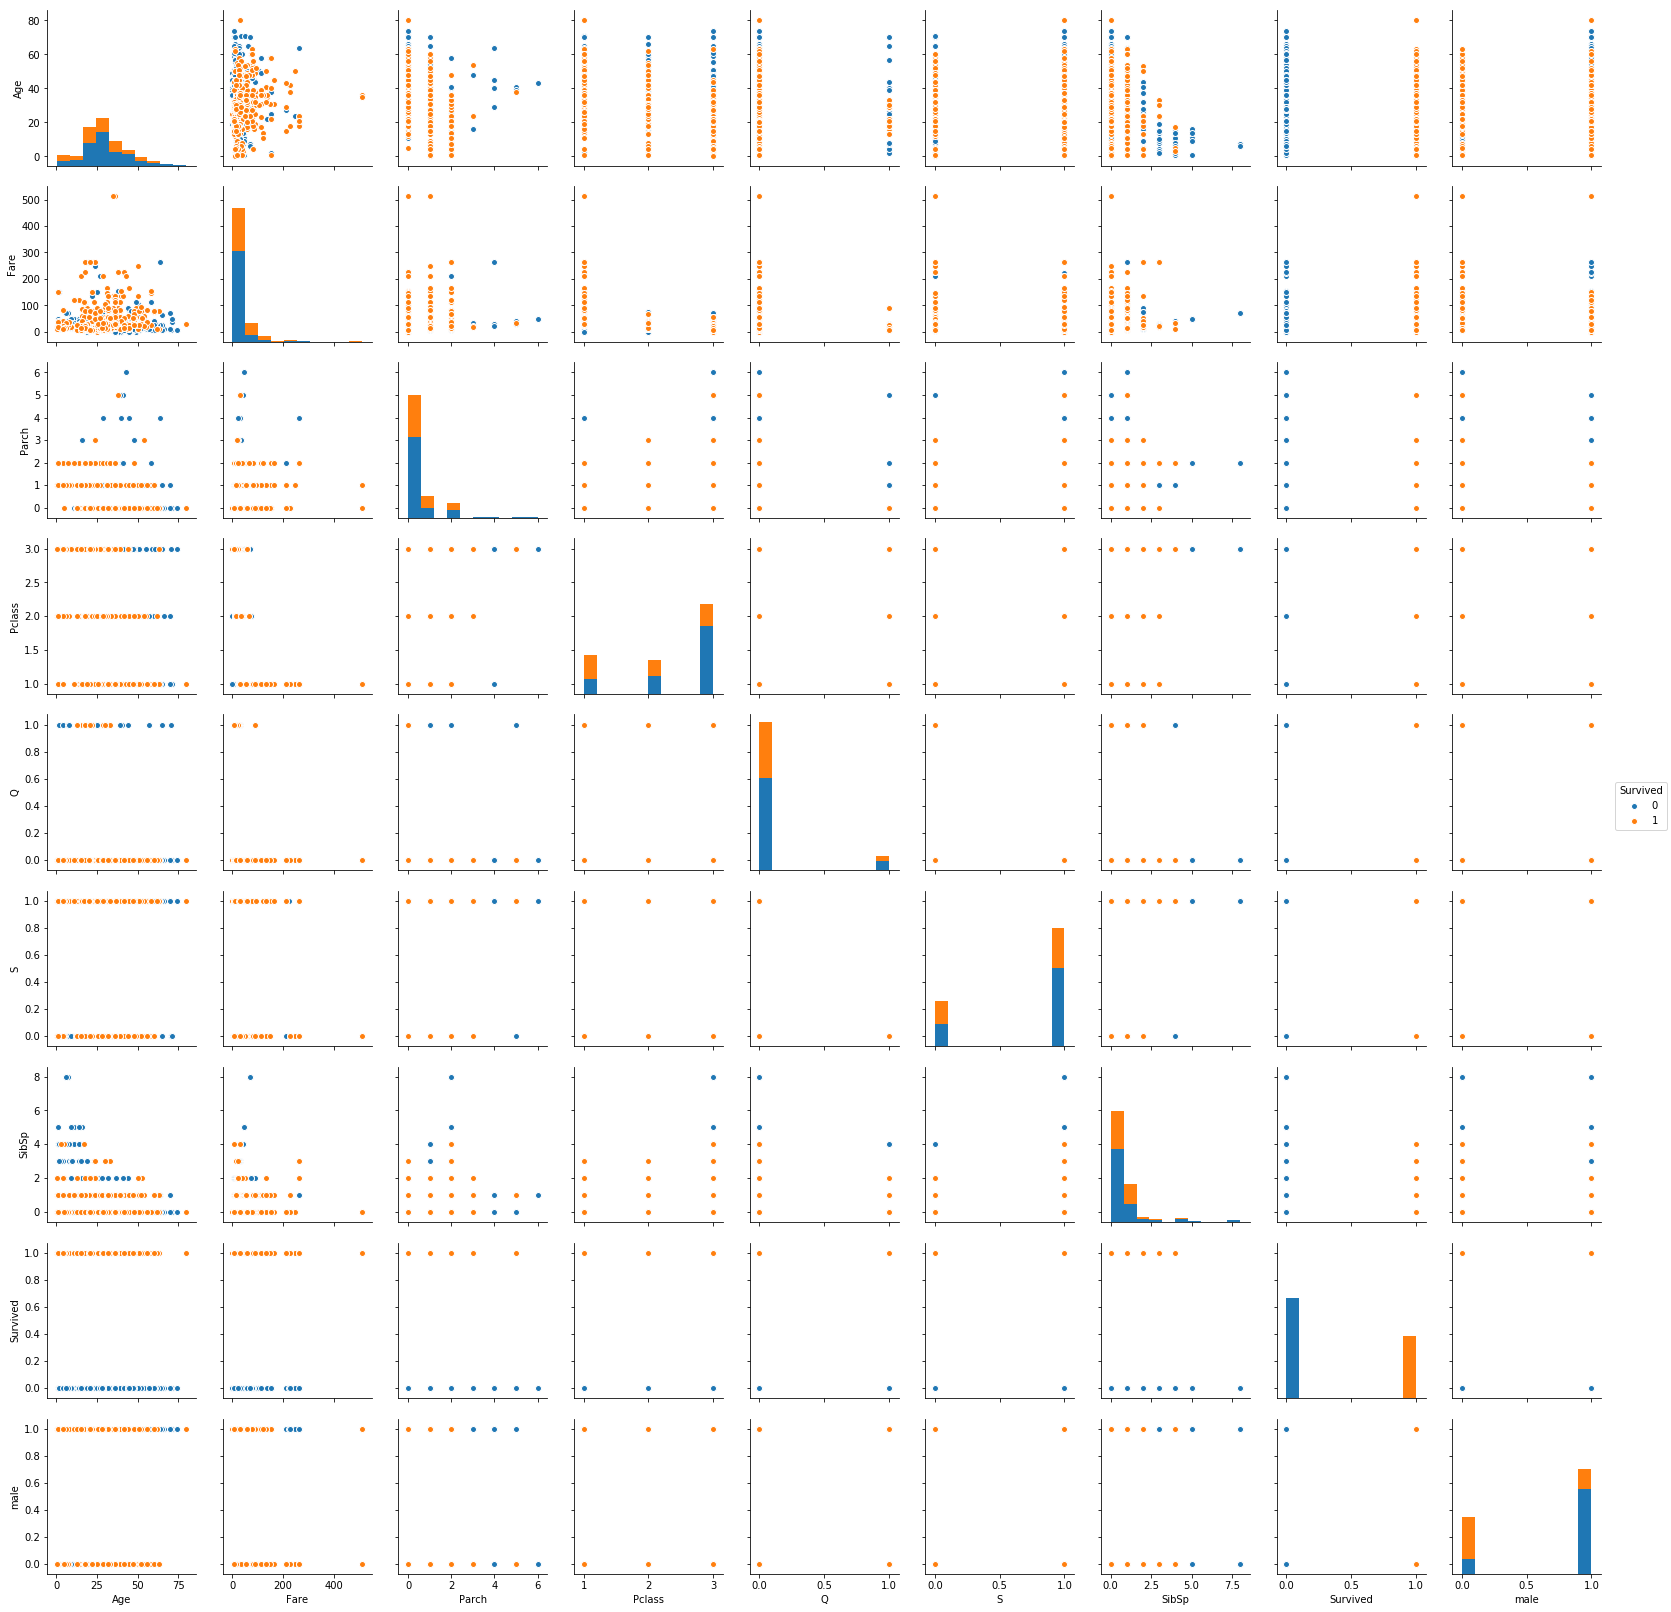

In [441]:
sns.pairplot(newTitanic, hue='Survived')

In [442]:
#Testing
y = newTitanic['Survived']
X = newTitanic.drop('Survived',axis=1)
X = X.drop('Parch',axis=1)
X = X.drop('SibSp',axis=1)
X = X.drop('Q',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [443]:
predictions = logmodel.predict(X_test)

In [444]:
print (classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.83      0.88      0.85       224
          1       0.77      0.69      0.73       132

avg / total       0.81      0.81      0.81       356



In [445]:
(accuracy_score(y_test, predictions)) * 100

80.89887640449437